In [30]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import kstest, norm
import scipy.stats as stats
from scipy.stats import spearmanr
from sklearn.preprocessing import PowerTransformer
from scipy.stats import kruskal
from scipy.stats import chi2_contingency

# 차원 축소
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 군집
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

# 학습 모델 저장을 위한 라이브러리
import pickle

### 가설5 : Segment 등급이 높을수록 보유한 신용카드 수가 많다.
 - 신용등급이 낮을수록 금융 접근성(카드 수 제한 등)이 낮을 수 있다고 생각하기에 분석 진행
 - 카드사 입장에서 연체 위험 회피를 위해 카드 한도 또는 개수 제한 가능성 있음!

In [2]:
# 데이터를 불러온다.
df1 = pd.read_parquet('open/train/1.회원정보/201807_train_회원정보.parquet')
df2 = pd.read_parquet('open/train/1.회원정보/201808_train_회원정보.parquet')
df3 = pd.read_parquet('open/train/1.회원정보/201809_train_회원정보.parquet')
df4 = pd.read_parquet('open/train/1.회원정보/201810_train_회원정보.parquet')
df5 = pd.read_parquet('open/train/1.회원정보/201811_train_회원정보.parquet')
df6 = pd.read_parquet('open/train/1.회원정보/201812_train_회원정보.parquet')

In [3]:
# 데이터 병합하기
# ignore_index = True : 인덱스를 새로 0부터 재부여한다.
df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index = True)
# 처음과 마지막 5개 행 출력해서 확인하기
# print(train_df.head())
# print(train_df.tail())

In [4]:
# 필요한 컬럼 추출
df_g5 = df[['Segment', '이용가능카드수_신용']].dropna()
df_g5

,Segment,이용가능카드수_신용
0,D,1
1,E,1
2,C,1
3,D,2
4,E,1
...,...,...
2399995,E,1
2399996,D,1
2399997,C,1
2399998,E,1


In [5]:
# 기본통계
df_g5.groupby('Segment')['이용가능카드수_신용'].describe()

,count,mean,std,min,25%,50%,75%,max
Segment,,,,,,,,
A,972.0,2.673868,1.241082,1.0,2.0,3.0,4.0,5.0
B,144.0,2.125000,1.228308,1.0,1.0,2.0,3.0,4.0
C,127590.0,2.319085,1.280782,0.0,1.0,2.0,3.0,5.0
D,349242.0,1.952217,1.121748,0.0,1.0,2.0,3.0,5.0
E,1922052.0,1.249146,0.762757,0.0,1.0,1.0,2.0,5.0


### 통계적 검정 이전 해당 컬럼 분석
 - 값 : 0, 1, 2, 3, 4, 5 
 - 갯수 데이터 = 이산형, 순서도 존재하며 간격도 동일
 - 이는 순서형과 수량형 특성을 모두 가짐
 - 그리고 이산형 수치형에 가까우므로 연속형 변수로 간주 가능
 - 연속형 변수와 동일하게 정규성 검정 실시 가능
 - 하지만, Q-Q plot을 확인해 보았을 때 해당 컬럼은 정규성을 만족하지 못하므로 비모수적인 검정 방법 실시
 - 따라서 Kruskal-Wallis H-test 실시
 - H-test에서 그룹간 차이가 유의하다면 사후검정 실시
 - 분포의 차이 그리고 평균의 차이에 대한 시각화를 위해 Boxplot과 평균 barplot 제시

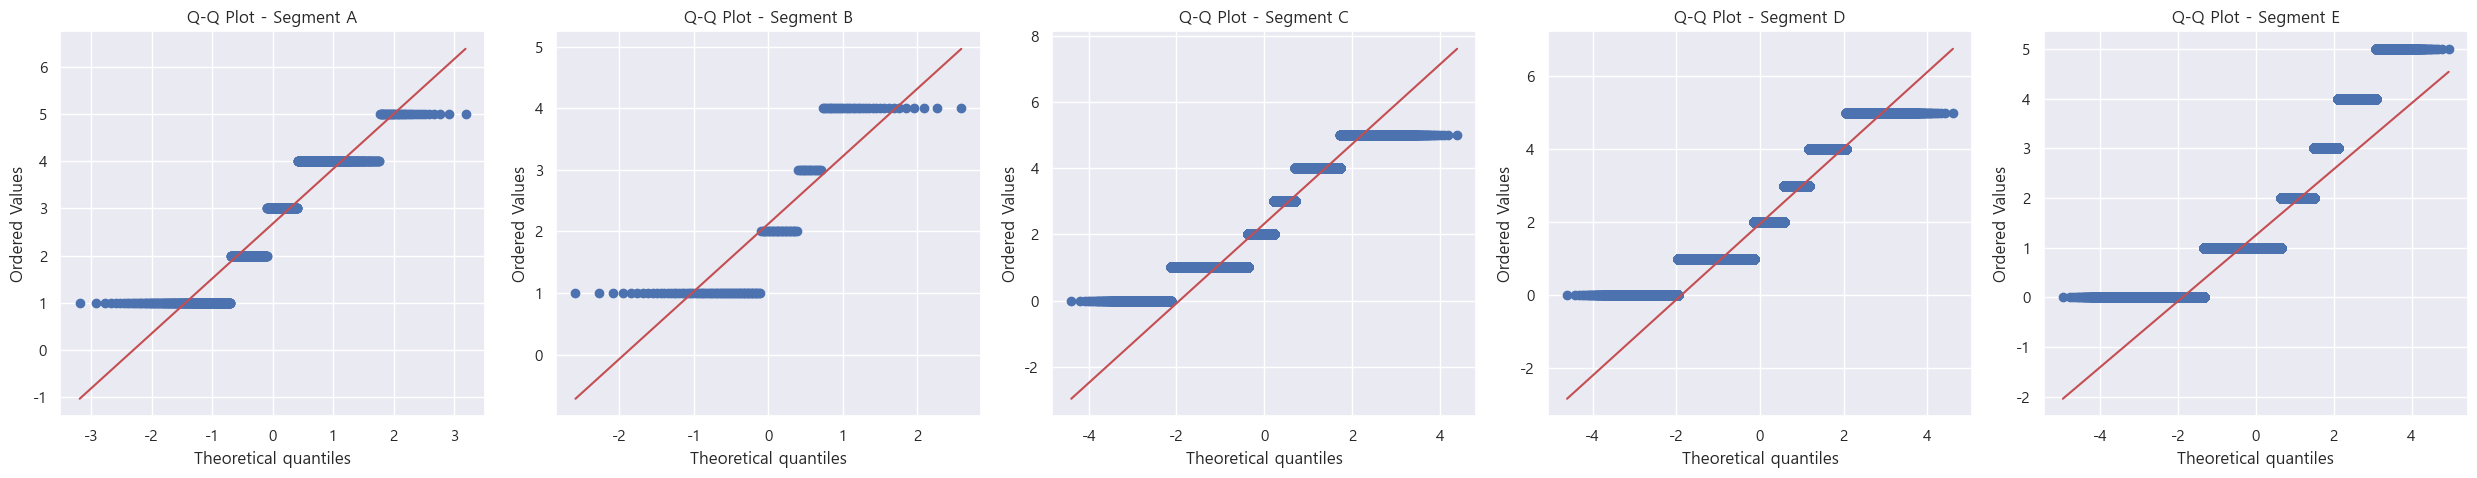

In [19]:
# Segment별 Q-Q Plot
segments = df_g5['Segment'].unique()
num_segments = len(segments)

plt.figure(figsize=(5 * num_segments, 5))

for i, seg in enumerate(sorted(segments)):
    plt.subplot(1, num_segments, i + 1)
    stats.probplot(
        df_g5[df_g5['Segment'] == seg]['이용가능카드수_신용'], 
        dist="norm", 
        plot=plt
    )
    plt.title(f"Q-Q Plot - Segment {seg}")

plt.tight_layout()
plt.show()

### 상관분석 
 - '이용가능카드수_신용'은 이산형이므로 정규성 검정 불가능 
 - 따라서 정규성 검정이 필요한 피어슨 상관분석보다는 Spearman 상관분석 진행

In [6]:
# 등급을 수치로 매핑 (예: A=5, ..., E=1)
segment_map = {'A': 5, 'B': 4, 'C': 3, 'D': 2, 'E': 1}
df_g5['Segment_score'] = df_g5['Segment'].map(segment_map)

# Spearman 상관분석
from scipy.stats import spearmanr
corr, p = spearmanr(df_g5['Segment_score'], df_g5['이용가능카드수_신용'])
print(f'Spearman 상관계수: {corr:.4f}, p-value: {p:.4f}')

Spearman 상관계수: 0.3119, p-value: 0.0000


 - p-value가 0.05미만이므로 Segment 등급별 이용가능한 신용카드 수 차이가 유의미함.
 - 상관계수는 0.3119이다.

### Krusakal-Wallis H-test
 - Segment 등급 간에 이용가능카드 수의 중앙값이나 분포 차이가 있는가?

In [7]:
# Segment별로 금액을 리스트로 분리
grouped_data = [
    df_g5[df_g5['Segment'] == seg]['이용가능카드수_신용'].dropna()
    for seg in sorted(df_g5['Segment'].unique())
]

In [8]:
# Kruskal-Wallis H-test 수행
stat, p = kruskal(*grouped_data)

# 결과값 출력
print(f"Kruskal-Wallis H-statistic: {stat:.4f}")
print(f"p-value: {p:.4f}")

if p < 0.05:
    print("→ 유의미한 차이가 있음. 귀무가설 기각됨")
else:
    print("→ 유의미한 차이가 없음. 귀무가설 채택.")

Kruskal-Wallis H-statistic: 234437.3443
p-value: 0.0000
→ 유의미한 차이가 있음. 귀무가설 기각됨


### 사후검정

In [9]:
import scikit_posthocs as sp

# 사후검정 실시
sp.posthoc_dunn(df_g5, val_col='이용가능카드수_신용', group_col='Segment', p_adjust='bonferroni')

,A,B,C,D,E
A,1.000000e+00,1.294394e-06,6.081508e-19,3.995540e-63,0.000000e+00
B,1.294394e-06,1.000000e+00,3.370778e-01,1.000000e+00,1.171528e-19
C,6.081508e-19,3.370778e-01,1.000000e+00,0.000000e+00,0.000000e+00
D,3.995540e-63,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
E,0.000000e+00,1.171528e-19,0.000000e+00,0.000000e+00,1.000000e+00


 - B와 D, B와 C 유의하지 않음
 - Segment B와 D, B와 C간 이용가능카드수_신용에 대한 차이가 유의하지 않음.
 - 나머지 그룹들 간 이용가능카드수_신용에 대한 차이는 유의함

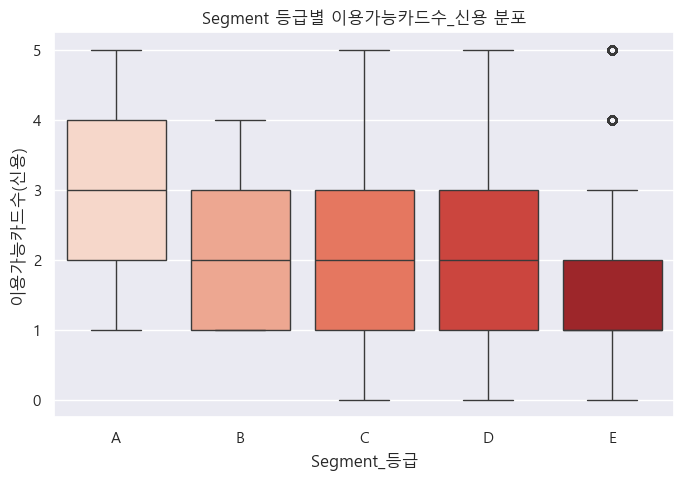

In [10]:
# Boxplot 시각화
plt.figure(figsize=(8, 5))
sns.boxplot(x='Segment', y='이용가능카드수_신용', data=df_g5, order=['A', 'B', 'C', 'D', 'E'], palette='Reds')
plt.title('Segment 등급별 이용가능카드수_신용 분포')
plt.ylabel('이용가능카드수(신용)')
plt.xlabel('Segment_등급')
plt.show()

- A등급에서 중앙값도 높고, 전체 카드 수 범위에 고르게 분포
- E등급에서는 중앙값이 가장 낮음
- 위 그래프를 보았을 때 중앙값이 A에서 E로 갈 수록 감소하는 모습을 보이고 있음.
- 사후검정분석이 의미가 있을 경우, B,C,D 사이에는 차이에 대한 분석이 유의미 하지 않기 때문에 A와 E간의 차이 위주로 분석 진행하면 될듯함

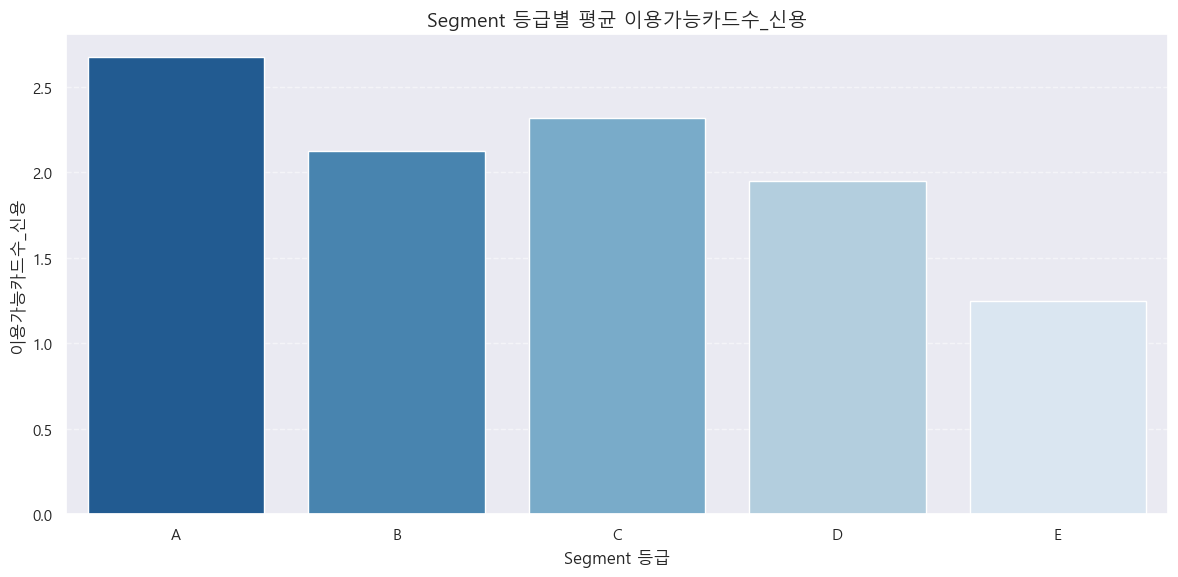

In [11]:
# Segment별 이용가능카드수_신용 bar plot
# 평균 이용가능카드수_신용
# A: 98294, B: 91296, C: 60613, D: 38603, E: 10054 
df_bar = df_g5.groupby('Segment')['이용가능카드수_신용'].mean().reset_index()
sns.barplot(x='Segment', y='이용가능카드수_신용', data=df_bar, palette='Blues_r')


plt.title('Segment 등급별 평균 이용가능카드수_신용', fontsize=14)
plt.xlabel('Segment 등급')
plt.ylabel('이용가능카드수_신용')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- 위 평균 막대 그래프를 보았을 때 A등급에서 이용가능한 신용카드수가  가장 높고, E등급에서 이용가능한 신용카드수가 낮다.
- 이를 통해 Segment등급이 높을수록 이용가능한 신용카드수가 많다라는 가설1을 입증 가능함

 Segment등급에 따라 이용가능한 신용카드 수는 통계적으로 유의한 차이를 보였다. 특히 A등급과 E등급 간 차이는 뚜렷하였으며, E등급은 모든 주요 등급과 유의미하게 낮은 카드 수를 보였다. 이는 신용등급이 금융접근성에 직접적인 영향을 준다는 정량적 근거로 해석할 수 있다.

In [18]:
# 여기까지 하였을때 그룹간 데이터 갯수의 차이가 너무 심하기 떄문에
# 지금까지한 모든 통계적인 분석이 의미없을 가능성 다수 존재
# 이에 비율 기반 분석을 추가적으로 실시
# 해당 비율을 통해 다음 2가지를 알 수 있다.
# 1. Segment별 카드 보유 수준 패턴
# 2. 신용등급과 카드 수 간의 관계 분석
# -> 신용등급이 높을수록 카드 보유 수가 많다? 적다?
# 2번을 통해서 해당 가설 입증 가능할듯함

In [20]:
# 이용가능카드수_신용 값별 count 계산
card_dist = df_g5.groupby(['Segment', '이용가능카드수_신용']).size().reset_index(name='count')
card_dist

,Segment,이용가능카드수_신용,count
0,A,1,236
1,A,2,213
2,A,3,192
3,A,4,294
4,A,5,37
5,B,1,66
6,B,2,28
7,B,3,16
8,B,4,34
9,C,0,2113


In [22]:
# 비율 계산
# Segment 별로 해당 Segment 전체 대비 해당 카드 수가 얼마나 차지하는지 비율 계산
card_dist['rate'] = card_dist['count'] / card_dist.groupby('Segment')['count'].transform('sum')

# 비율 옆에 'Segment'와 '이용가능카드수_신용' 컬럼 추가
print(card_dist[['Segment', '이용가능카드수_신용', 'rate']].to_string(index=True))

   Segment  이용가능카드수_신용      rate
0        A           1  0.242798
1        A           2  0.219136
2        A           3  0.197531
3        A           4  0.302469
4        A           5  0.038066
5        B           1  0.458333
6        B           2  0.194444
7        B           3  0.111111
8        B           4  0.236111
9        C           0  0.016561
10       C           1  0.341727
11       C           2  0.226922
12       C           3  0.176652
13       C           4  0.197131
14       C           5  0.041006
15       D           0  0.024822
16       D           1  0.420694
17       D           2  0.271505
18       D           3  0.162856
19       D           4  0.100669
20       D           5  0.019454
21       E           0  0.092284
22       E           1  0.651920
23       E           2  0.188604
24       E           3  0.049754
25       E           4  0.016436
26       E           5  0.001003


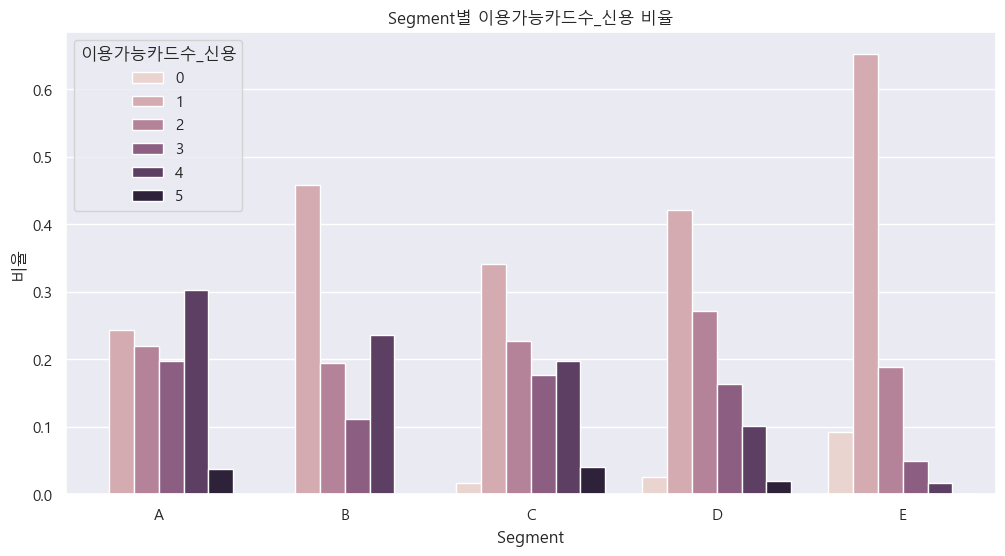

In [27]:
# 위 비율에 추가적으로 시각화 진행 (Bar_plot)
# 파이차트로 나타내는게 훨씬 보기 좋을듯?
# Segment별 카드 수 분포
sns.barplot(data=card_dist, x = 'Segment', y='rate', hue='이용가능카드수_신용')
plt.title("Segment별 이용가능카드수_신용 비율")
plt.ylabel("비율")
plt.show()

### Segment A (상위 등급 추정)
 - 4개 카드 보유자 비율 높음
 - 카드 보유 수가 다양하게 분포 → 신용도 높고 금융 활용도가 높다고 추정 가능

### Segment B
 - 1개 카드 보유자 비중 압도적
 - 왜 Segment B에서 신용카드 1개의 비율이 가장 큰거지?
 - 특정 카드사나 정책에 의해 일부 고객은 한 개의 카드만 발급받는 조건?
 - 예를 들면 저소득/사회초년생 등 신용이 중간이지만 금융 이력 짧은 계층
 - 만약 그렇다면 Segment B에 대하여 나이대 비율도 볼 필요성이 있다.
 - 그 외 4개 카드 보유자도 많음 

### Segment C
 - 1~4개 사이에 고르게 분포
 - 다소 안정적이나 상위도 하위도 아님 → 중하위 추정

### Segment D
 - 1개 카드 보유자가 가장 많고, 그 뒤로 2~3개 보유자가 있음
 - 평균적으로 카드 수가 적은 편 → 하위 등급 가능성

### Segment E (최하위 추정)
 - 1개 카드만 가진 고객이 65% 이상
 - 2개 이상 가진 고객 비율 매우 낮음
 - 카드 발급이 어려운 저신용자 성향

### 카이제곱 독립성 검정 실시
 - Segment와 이용가능카드수_신용 간의 관계가 통계적으로 유의미한지 확인
 - 귀무가설(H₀): Segment와 이용가능카드수_신용은 서로 독립적이다.
 - 대립가설(H₁): 두 변수는 연관이 있다.

In [29]:
# Segment별 이용가능카드수_신용의 빈도표(contingency table)
contingency = card_dist.pivot(index='Segment', columns='이용가능카드수_신용', values='count').fillna(0)
contingency

이용가능카드수_신용,0,1,2,3,4,5
Segment,,,,,,
A,0.0,236.0,213.0,192.0,294.0,37.0
B,0.0,66.0,28.0,16.0,34.0,0.0
C,2113.0,43601.0,28953.0,22539.0,25152.0,5232.0
D,8669.0,146924.0,94821.0,56876.0,35158.0,6794.0
E,177375.0,1253024.0,362506.0,95629.0,31590.0,1928.0


In [37]:
# 카이제곱 독립성 검정 수행
# 기대도수(expected) 
# 1) 각 행의 합과 열의 합을 곱해서 전체합으로 나눈 값
# 2) 관계각 없을 때의 예상값
# 즉, 실제값과 기대값이 다를수록 두 변수 간 관련성이 크다라는 증거가 된다.
chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi-squared statistic: {chi2:.4f}")
print(f"p-value: {p:.6f}")
print(f"Degrees of Freedom: {dof}")

Chi-squared statistic: 338671.6626
p-value: 0.000000
Degrees of Freedom: 20


 - 유의확률이 0.05보다 작으므로 귀무가설 기각
 - 즉, Segment와 이용가능카드수_신용 간에는 유의미한 연관이 있다.

### 잔차 히트맵
 - 기대도수 vs 실제도수 차이 보기
 - 카이제곱 검정을 통해 위 두 개의 컬럼 사이에는 유의미한 연관이 있음을 알 수 있다.
 - 그럼 잔차 히트맵을 통해 각 Segment와 카드 수 조합이 기대값보다 얼마나 많거나 적은지 확인한다.

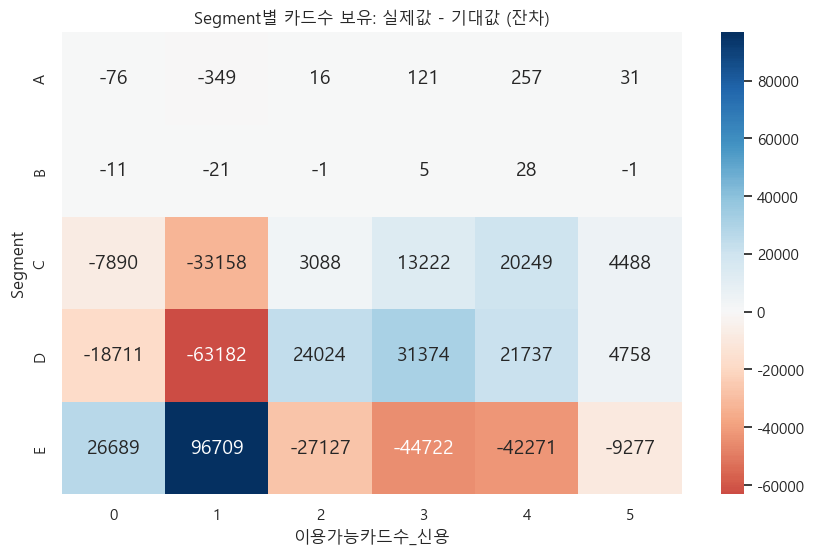

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# 기대도수 - 실제도수 차이
# 양수(파란색) : 실제값이 기대값보다 많음(과대표집)
# 음수(붉은색) : 실제값이 기대값보다 적음(과소대표)
# 회색 ~ 중간색 : 관계 없음에 가까움
# 값의 절댓값이 클수록 해당 셀이 전체 X^2 통계량에 더 많이 기여
residuals = contingency - expected

plt.figure(figsize=(10, 6))
sns.heatmap(residuals, annot=True, cmap='RdBu', center=0, fmt=".0f")
plt.title("Segment별 카드수 보유: 실제값 - 기대값 (잔차)")
plt.ylabel("Segment")
plt.xlabel("이용가능카드수_신용")
plt.show()

### Segment A (중립적 패턴)
 - Segment A는 전체적으로 기대값과 비슷한 카드수 분포
 - 특정 카드 수에 쏠림 없는 평균적 그룸

### Segment B (거의 완전한 중립)
 - Segment B도 A와 마찬가지로 기대값에 매우 근접한 분포를 보인다.
 - 이에 두 변수간에 통계적으로 독립적인 관계가 있음을 알 수 있다.
 - 즉, 카드 수 특성이 이 그룹에서는 차별화 요인이 아님을 나타낸다.

### Segment C
 - Segment C는 신용카드 1개 카드 보유자가 기대보다 크게 과소표집되어 있으며, 2~4개 카드 보유자가 과대표집이 되어 있다.
 - 어느정도 다카드 보유자 성향을 보이는 그룹이다.

### Segment D 
 - D는 1개 카드 보유자가 심하게 부족하고, 2~4개 카드 보유자가 매우 많다.
 - 즉, 이 그룹은 다카드 사용자 중심의 구조를 가진다.

### Segment E
 - Segment E는 1개 카드 보유자에 거의 몰림
 - 다카드 발급이 어려운 금융취약계층 혹은 신용저등급자로 보일가능성이 높다.

### 결론
- Segment가 높을수록 다카드 사용자 비중이 높고,반대로 Segment가 낮을수록 단카드 사용자에 집중되어 있어,
카드 수 보유는 신용등급의 사회경제적 특성과 밀접한 연관이 있다.

### 가설8 : 신용카드를 다양하게 사용하는 고객일수록 신용등급이 높다.
 - 해당 가설도 위 히트맵을 통해서 설명 가능
